# Desagregación

Implementación del modelo mejor evaluado en la etapa de validación, correspondiente al modelo FHMM entrenado con datos promedio de potencia activa recopilados cada 30 segundos.

Librerías y otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.utils import print_dict

labels =['M1','M2', 'Fridge', 'AACC', 'AACC', 'Washing machine','Computer','Clothes iron','unknown','Tv','Wet appliance','Motor']
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan','tab:grey']

## Set de Pruebas

In [2]:
test =DataSet('iawe.h5')
test.set_window(start="2013-09-17 05:30:00", end="2013-09-18 08:40:00")



test_elec = test.buildings[1].elec

#test_elec = test_elec.select(instance=[2,3,4,5,6,7,8,9,10,11,12])



test_Main=test_elec.mains() #medidor principal de cabecera
test_Main

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
)

In [3]:
test_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=8, building=1, dataset='iAWE', appliances=[Appliance(type='clothes iron', instance=1)])
  ElecMeter(instance=9, building=1, dataset='iAWE', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=10, building=1, dataset='iAWE', appliances=[A

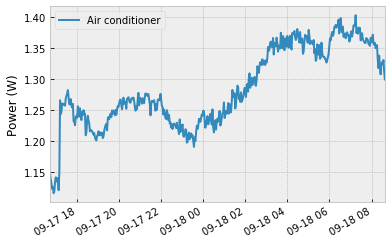

In [4]:
test_elec.plot()

Usaremos como periodo de sampleo =600s

## Desagregación

In [5]:
from nilmtk.legacy.disaggregate import FHMM
from nilmtk import HDFDataStore

train = DataSet('iawe.h5')

train.set_window(start="2013-07-24 05:30:00", end="2013-07-25 05:24:00")
train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[3,4,5,6,7,8,9,10,11,12])
train_Devices


#Set para validación
valid = DataSet('iawe.h5')
valid.set_window(start="2013-07-24 05:30:00", end="2013-08-24 05:30:00")
valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[3,4,5,6,7,8,9,10,11,12])
print(valid_Devices)


#Vamos a  volver a ejecutar esto
#FHMM_test.import_model('C:/data/FHMM_30seg_median_model.pickle') #modelo FHMM elegido


from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM


periods = { '10min':60*10}
methods = [ 'mean']
times = {}

data_dir = './data/'
times = {} #almacena tiempos de ejecución
null={} #diccionario nulo


for sp_name, sp in periods.items():
    t = []
    for method in methods:
        models={'FHMM':FHMM()}
        for model_name, model in models.items():
            model.MIN_CHUNK_LENGTH = 1   
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)   
            import time
            start = time.time()
            model.train(train_Devices,
                num_states_dict={}, #diccionario de estados nulo, por defecto
                ac_type='active', #potencia activa, por defecto
                sample_period=1, #cambio de muestreo
                resample_kwargs={'how':'first'})#método 

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guardamso el  modelo entrenado
            #Falla  al exprtarlo como model.pickle asi que lo salvamos en formato h5
            #model_dir = dir_models + model_name + '_1s_first_model.pickle'
            #print(model_dir)
            #model.export_model(model_dir) 
            output=HDFDataStore(data_dir+'NILM/Results/test_results.h5', 'w')
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            end = time.time()-start
            t.append(round(end,2))  

    times[sp_name] = t

  
            
    
print('\n\nDone!')



Medidor de cabecera para desagregación:
MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
)

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=8, building=1, dataset='iAWE', appliances=[Appliance(type='clothes iron', instance=1)])
  ElecMeter(instance=9, building=1, dataset='iAWE', appliance

Visualizar los datos de entrenamiento


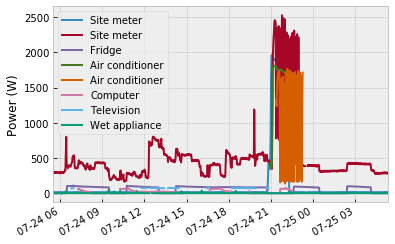

In [6]:
train_elec.plot()

Visualizar los datos de prueba

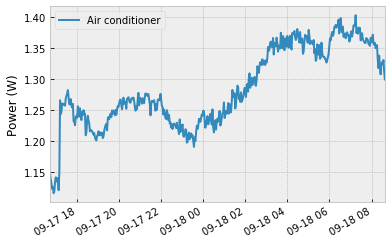

In [7]:
test_elec.plot()

### Resultados

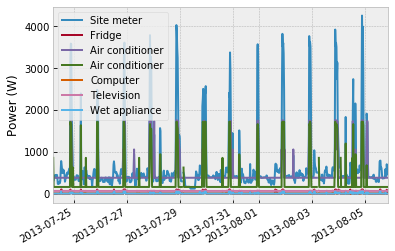

In [8]:
results=DataSet(data_dir+'NILM/Results/test_results.h5')
results_elec=results.buildings[1].elec # Todos los medidores
results_Main=results_elec.mains() #medidor de cabecera
results_Devices=results_elec.submeters() #predicciones

results_elec.plot()

### Metadatos

In [9]:
print_dict(results.metadata)

In [10]:
print_dict(results.buildings[1].metadata)

In [11]:
print_dict(results_elec[1].get_metadata())

## Análisis Gráfico

### Todos los resultados

7/7 ElecMeter(instance=11, building=1, dataset='FHMM', appliances=[Appliance(type='wet appliance', instance=1)]))

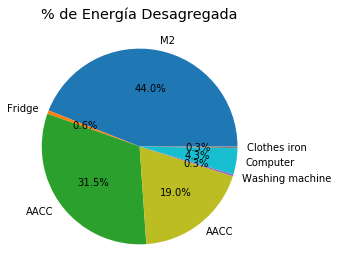

In [12]:
d1=results_elec.fraction_per_meter()
ax1=d1.plot(autopct=lambda p:'{:.1f}%'.format(p), kind='pie',
            labels=labels[1:]+list(['Others']), figsize=(4.5,4.5),
            colors=colors)
ax1.set(ylabel="")
ax1.set(title='% de Energía Desagregada')
#guarda gráfico
plt.savefig('./data/images/6.2_Plot_results_1.1.svg', bbox_inches='tight', transparent=True)

6/6 ElecMeter(instance=11, building=1, dataset='FHMM', appliances=[Appliance(type='wet appliance', instance=1)]))

[Text(0.5, 1.0, 'Pred')]

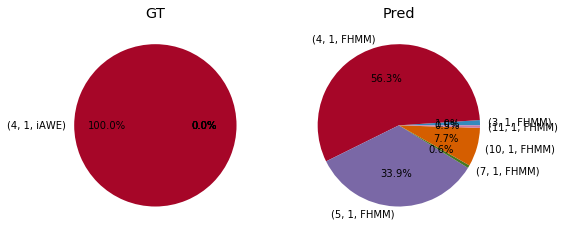

In [18]:
rcParams['figure.figsize'] = (8, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)
test_elec.select(instance=[3,4,5,7,10,11]).fraction_per_meter().plot(ax=ax1, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')
results_elec.select(instance=[3,4,5,7,10,11]).fraction_per_meter().plot(ax=ax2, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')
ax1.set(ylabel="")
ax1.set(title='GT')
ax2.set(ylabel="")
ax2.set(title='Pred')

In [19]:
rcParams['figure.figsize'] = (6, 5)

df_d=test_elec.select(instance=[1]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(test_elec[1].load(ac_type='active')).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['1','2', '3', '4','5','6','7', '8','9'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,3200)

TypeError: no numeric data to plot

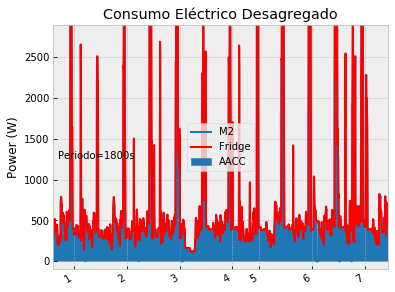

In [20]:
rcParams['figure.figsize'] = (6, 5)

df_d=results_elec.select(instance=[1]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(results_elec[1].load()).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['1','2', '3', '4','5','6','7', '8','9'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2900)
#guarda gráfico
plt.savefig('./data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)
pass

In [21]:
#Energía de dispositivos
e_d=round(results_elec.energy_per_meter().transpose()['active'][1:],1)
print('\n\nEnergía de Dispositivos:')
print(e_d)

#Energía total de dispositivos
e_t=round(sum(e_d),2)
print('\nEnergía Total Dispositivos: '+str(e_t))

#energía medida por Mains_RST
e_m=round(results_elec.mains().total_energy(),1)
print('\nEnergía Main Principal: '+str(e_m[0]))

#energía no medida
print('\nEnergía No medida: '+str(e_m[0]-e_t))

7/7 ElecMeter(instance=11, building=1, dataset='FHMM', appliances=[Appliance(type='wet appliance', instance=1)]))

Energía de Dispositivos:
(3, 1, FHMM)       2.6
(4, 1, FHMM)     140.8
(5, 1, FHMM)      84.8
(7, 1, FHMM)       1.4
(10, 1, FHMM)     19.3
(11, 1, FHMM)      1.2
Name: active, dtype: float64

Energía Total Dispositivos: 250.1

Energía Main Principal: 196.5

Energía No medida: -53.599999999999994


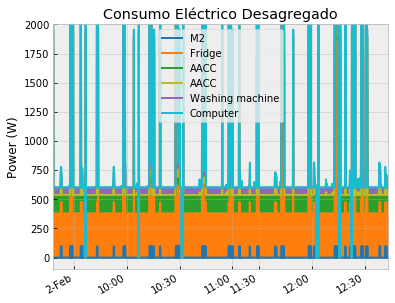

In [23]:
rcParams['figure.figsize'] = (6, 5)

df_d=results_elec.select(instance=[3,4,5,7,10,11]).dataframe_of_meters(ac_type='active')

ax1 = df_d.plot(kind='area',color=colors)   
#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['2-Feb','10:00', '10:30', '11:00','11:30','12:00','12:30', '13:00','13:15'])
ax1.set(ylabel='Power (W)')
#ax1.annotate("Periodo=30s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2000)
#guarda gráfico
plt.savefig('./data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)